In [1]:
import sys
sys.path.append('../') 

In [74]:

%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import seaborn as sns
sns.set()

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from fit_and_predict import fit_and_predict


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



## Params:

In [75]:
aggregate_by_state = False
outcome_type = 'cases'

## Basic Data Visualization

In [76]:
# Just something to quickly summarize the number of cases and distributions each day

In [77]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(data_dir = '../data/')
df = df.sort_values('#Deaths_3/30/2020', ascending=False)
# outcome_cases = load_data.outcome_cases # most recent day
# outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)
very_important_vars = ['PopulationDensityperSqMile2010',
#                        'MedicareEnrollment,AgedTot2017',
                       'PopulationEstimate2018',
                       '#ICU_beds',
                       'MedianAge2010',
                       'Smokers_Percentage',
                       'DiabetesPercentage',
                       'HeartDiseaseMortality',
                        '#Hospitals'
#                        'PopMale60-642010',
#                         'PopFmle60-642010',
#                          'PopMale65-742010',
#                          'PopFmle65-742010',
#                          'PopMale75-842010',
#                          'PopFmle75-842010',
#                          'PopMale>842010',
#                          'PopFmle>842010'
                      ]

In [78]:
def sum_lists(list_of_lists):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)
if aggregate_by_state:
    # Aggregate by State
    state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
    state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
    df =  pd.concat([state_cases_df,state_deaths_df],axis =1 )

Number of counties with non-zero cases
2049


(array([86., 66., 36., 22., 18., 17., 21., 13., 10., 13.,  9., 10.,  4.,
         6.,  3., 10.,  6.,  5.,  6.,  9.,  2.,  0.,  4.,  4.,  1.,  1.,
         4.,  3.,  2.,  1.,  3.,  3.,  3.,  2.,  0.,  1.,  1.,  2.,  2.,
         0.,  3.,  3.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
         1.,  0.,  0.,  2.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([ 21.  ,  29.53,  38.06,  46.59,  55.12,  63.65,  72.18,  80.71,
         89.24,  97.77, 106.3 , 114.83, 123.36, 131.89, 140.42, 148.95,
        157.48, 166.01, 174.54, 183.07, 191.6 , 200.13, 208.66, 217.19,
        225.72, 234.25, 242.78, 251.31, 259.84, 268.37, 276.9 , 285.43,
        293.96, 302.49, 311.02, 319.55, 328.08, 336.61, 345.14, 353.67,
        362.2 , 370.73, 379.26, 387.79, 396.32, 404.85, 413.38, 421.91,
  

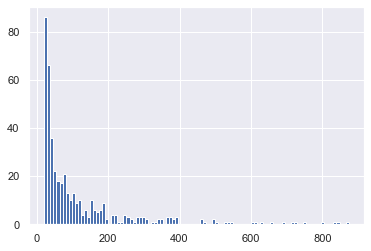

In [79]:
# Distribution of the maximum number of cases
_cases = list(df['cases'])

max_cases = []
for i in range(len(df)):
    max_cases.append(max(_cases[i]))

print('Number of counties with non-zero cases')
print(sum([v >0 for v in max_cases]))


# cases truncated below 20 and above 1000 for plot readability
plt.hist([v for v in max_cases if v > 20 and v < 1000],bins = 100)


In [80]:
sum(max_cases)

157498

In [81]:
print(sum([v > 50 for v in max_cases]))


272


In [82]:
np.quantile(max_cases,.5)

2.0

Number of counties with non-zero deaths
446


(array([51.,  6.,  4.,  4.,  2.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([  6.        ,  15.96666667,  25.93333333,  35.9       ,
         45.86666667,  55.83333333,  65.8       ,  75.76666667,
         85.73333333,  95.7       , 105.66666667, 115.63333333,
        125.6       , 135.56666667, 145.53333333, 155.5       ,
        165.46666667, 175.43333333, 185.4       , 195.36666667,
        205.33333333, 215.3       , 225.26666667, 235.23333333,
        245.2       , 255.16666667, 265.13333333, 275.1       ,
        285.06666667, 295.03333333, 305.        ]),
 <a list of 30 Patch objects>)

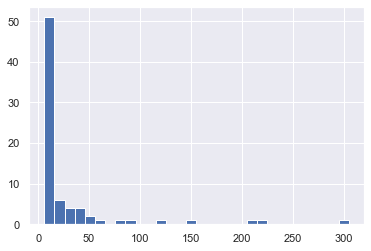

In [83]:
# Distribution of the maximum number of cases
_deaths = list(df['deaths'])

max_deaths = []
for i in range(len(df)):
    max_deaths.append(max(_deaths[i]))

    
print('Number of counties with non-zero deaths')
print(sum([v > 0 for v in max_deaths]))
# plt.hist(max_cases)

# print(sum([v >0 for v in max_cases]))
plt.hist([v for v in max_deaths if v > 5],bins=30)

In [84]:
sum(max_deaths)

2799.0

In [85]:
max(max_deaths)

305.0

In [86]:
np.quantile(max_deaths,.7)

0.0

### Clean data

In [87]:
# Remove counties with zero cases
max_cases = [max(v) for v in df['cases']]
df['max_cases'] = max_cases
max_deaths = [max(v) for v in df['deaths']]
df['max_deaths'] = max_deaths
df =  df[df['max_cases'] > 0]



## Predict data from model:

In [88]:
method_keys = []

In [89]:
# clear predictions
for m in method_keys:
    del df[m]
    

In [90]:
# target_day = np.array([1])
# # Trains model on train_df and produces predictions for the final day for test_df and writes prediction
# # to a new column for test_df 
# # fit_and_predict(df, method='exponential', outcome=outcome_type, mode='eval_mode',target_day=target_day)
# # fit_and_predict(df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',target_day=target_day)
# # fit_and_predict(train_df, test_df,'shared_exponential', mode='eval_mode',demographic_vars=important_vars)
# # fit_and_predict(df,method='shared_exponential', outcome=outcome_type, mode='eval_mode',demographic_vars=very_important_vars,target_day=target_day)
# fit_and_predict(df, outcome=outcome_type, mode='eval_mode',demographic_vars=[],
#                                      method='ensemble',target_day=target_day)
# fit_and_predict(df, outcome=outcome_type, mode='eval_mode',demographic_vars=[],
#                                      method='ensemble',target_day=np.array([1,2,3]))
# # fit_and_predict(train_df, test_d f,method='exponential',mode='eval_mode',target_day = np.array([1,2]))

# # Finds the names of all the methods
# method_keys = [c for c in df if 'predicted' in c]
# method_keys

In [91]:
# for days_ahead in [1, 2, 3]:
#      for method in ['exponential', 'shared_exponential', 'ensemble']:  
#         fit_and_predict(df, method=method, outcome=outcome_type, mode='eval_mode',target_day=np.array([days_ahead]))
        
#         if method == 'shared_exponential':
#             fit_and_predict(df,method='shared_exponential', 
#                             outcome=outcome_type, 
#                              mode='eval_mode',
#                              demographic_vars=very_important_vars,
#                              target_day=np.array([days_ahead]))
# method_keys = [c for c in df if 'predicted' in c]
# geo = ['countyFIPS', 'CountyNamew/StateAbbrev']

In [92]:
# method_keys = [c for c in df if 'predicted' in c]
# df_preds = df[method_keys + geo + ['deaths']]
# df_preds.to_pickle("multi_day_6.pkl")

## Ensemble predictions

In [93]:
exponential = {'model_type':'exponential'}
shared_exponential = {'model_type':'shared_exponential'}
demographics = {'model_type':'shared_exponential', 'demographic_vars':very_important_vars}
linear = {'model_type':'linear'}

In [94]:
# import fit_and_predict
# for d in [1, 2, 3]:
#     df = fit_and_predict.fit_and_predict_ensemble(df, 
#                                                   target_day=np.array([d]),
#                                                   mode='eval_mode',
#                                                   outcome=outcome_type,
#                                                   output_key=f'predicted_{outcome_type}_ensemble_{d}'
#                                                    )

In [95]:
import fit_and_predict
for d in [[1], [1,2,3]]:
    df = fit_and_predict.fit_and_predict_ensemble(df, 
                                                  target_day=np.array(d),
                                                  mode='eval_mode',
                                                  outcome=outcome_type,
                                                 methods=[exponential, 
                                                        shared_exponential
#                                                           demographics,
#                                                           linear
                                                         ],
                                                  output_key=f'predicted_{outcome_type}_ensemble_{d[-1]}'
                                                   )

In [96]:
method_keys = [c for c in df if 'predicted' in c]

In [97]:
# df = fit_and_predict.fit_and_predict_ensemble(df)

In [99]:
method_keys

['predicted_cases_ensemble_1', 'predicted_cases_ensemble_3']

## Evaluate and visualize models

### Compute MSE and log MSE on relevant cases

In [100]:
# TODO: add average rank as metric

In [101]:
# Computes the mse in log space and non-log space for all columns

In [102]:
def l1(arr1,arr2,norm=True):
    """
    arr2 ground truth
    arr1 predictions
    """
    if norm:
        sum_percent_dif = 0
        for i in range(len(arr1)):
            sum_percent_dif += np.abs(arr2[i]-arr1[i])/arr1[i]
        return sum_percent_dif/len(arr1)
            
    return sum([np.abs(a1-a2) for (a1,a2) in zip(arr1,arr2)])/len(arr1)
mse = sklearn.metrics.mean_squared_error
# Only evaluate points that exceed this number of deaths 
# lower_threshold, upper_threshold = 10, 100000
lower_threshold, upper_threshold = 10, np.inf

In [103]:

# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][(outcome > lower_threshold)]] # * (outcome < upper_threshold)]]
    print('Log scale MSE for '+key)
    print(mse(np.log(outcome[(outcome > lower_threshold) * (outcome < upper_threshold)] + 1),preds))

Log scale MSE for predicted_cases_ensemble_1
0.03342253336708497
Log scale MSE for predicted_cases_ensemble_3
0.18469279606483388


In [104]:
# Log scaled
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1] + 1) for p in df[key][outcome > lower_threshold]]
    print('Log scale l1 for '+key)
    print(l1(np.log(outcome[outcome > lower_threshold] + 1),preds))

Log scale l1 for predicted_cases_ensemble_1
0.03955004997773341
Log scale l1 for predicted_cases_ensemble_3
0.10221902257044516


In [105]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw MSE for '+key)
    print(mse(outcome[outcome > lower_threshold],preds))

Raw MSE for predicted_cases_ensemble_1
2503.339646561852
Raw MSE for predicted_cases_ensemble_3
56967.847470386354


In [106]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds))

Raw l1 for predicted_cases_ensemble_1
0.14138076623225437
Raw l1 for predicted_cases_ensemble_3
0.46245918957314697


In [107]:
# No log scale
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > lower_threshold]]
    print('Raw l1 for '+key)
    print(l1(outcome[outcome > lower_threshold],preds,norm=False))

Raw l1 for predicted_cases_ensemble_1
15.702192279696032
Raw l1 for predicted_cases_ensemble_3
56.27341453693248


### Plot residuals

In [108]:
# TODO: Create bounds automatically, create a plot function and call it instead of copying code, figure out way
# to plot more than two things at once cleanly

# Creates residual plots log scaled and raw
# We only look at cases with number of deaths greater than 5

In [109]:
def method_name_to_pretty_name(key):
    # TODO: hacky, fix
    words = key.split('_')
    words2 = []
    for w in words:
        if not w.isnumeric():
            words2.append(w)
        else:
            num = w
            
    model_name = ' '.join(words2[2:])
#     model_name = 'model'
    if num == '1':
        model_name += ' predicting 1 day ahead'
    else:
        model_name += ' predicting ' +w+' days ahead'
        
    return model_name

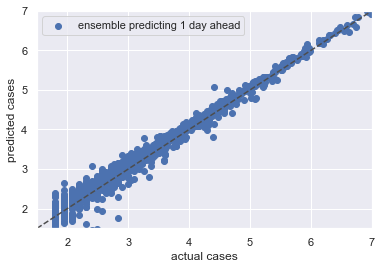

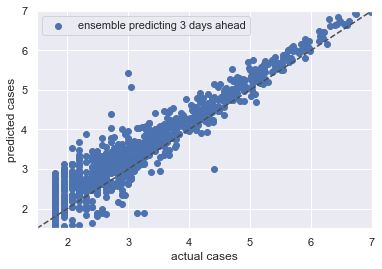

In [110]:
# Make log plots:
bounds = [1.5, 7]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=method_name_to_pretty_name(key))
    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

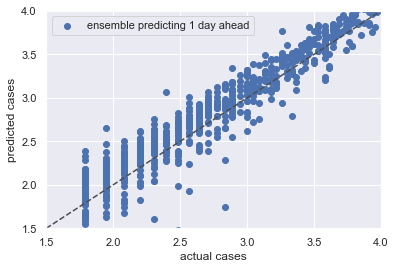

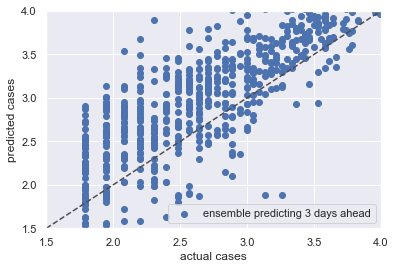

In [111]:
# Make log plots zoomed in for the counties that have a fewer number of deaths
bounds = [1.5, 4]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [np.log(p[-1]) for p in df[key][outcome > 5]]
    plt.scatter(np.log(outcome[outcome > 5]),preds,label=method_name_to_pretty_name(key))

    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

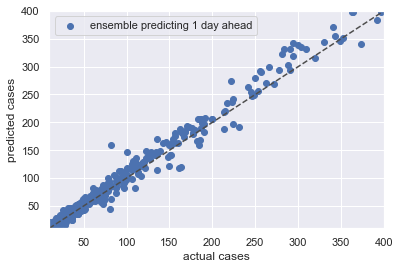

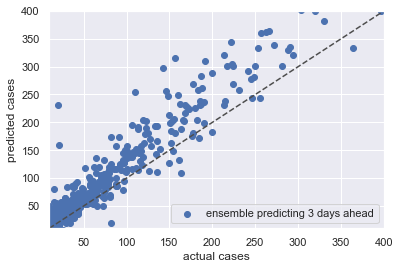

In [112]:
# Make non-log plots zoomed in for the counties that have a fewer number of deaths# We set bounds 
bounds = [10,400]
outcome = np.array([df[outcome_type].values[i][-1] for i in range(len(df))])
for key in method_keys:
    preds = [p[-1] for p in df[key][outcome > 5]]
    plt.scatter(outcome[outcome > 5],preds,label=method_name_to_pretty_name(key))

    plt.xlabel('actual '+outcome_type)
    plt.ylabel('predicted '+outcome_type)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.legend()

    plt.plot(bounds, bounds, ls="--", c=".3")
    plt.show()

### Graph Visualizations

In [113]:
# Here we visualize predictions on a per county level.
# The blue lines are the true number of deaths, and the dots are our predictions for each model for those days.

In [114]:
def plot_prediction(row):
    """
    Plots model predictions vs actual
    row: dataframe row
    window: autoregressive window size
    """
    gold_key = outcome_type
    for i,val in enumerate(row[gold_key]):
        if val > 0:
            start_point = i
            break
#     plt.plot(row[gold_key][start_point:], label=gold_key) 
    if len(row[gold_key][start_point:]) < 3:
        return
    sns.lineplot(list(range(len(row[gold_key][start_point:]))),row[gold_key][start_point:], label=gold_key)
    
    

    for key in method_keys:
        preds = row[key]

        sns.scatterplot(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=method_name_to_pretty_name(key))
        
#         plt.scatter(list(range(len(row[gold_key][start_point:])))[-len(preds):],preds,label=key)
    
#     plt.legend()
#     plt.show()
#     sns.legend()
    plt.title(row['CountyName']+' in '+row['StateNameAbbreviation'])
    plt.ylabel(outcome_type)
    plt.xlabel('Days since first death')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.figure(dpi=500)    
    plt.show()

    

In [115]:
# feature_vals = {
# 'PopulationDensityperSqMile2010' : 1.1525491065255939e-05,
# "MedicareEnrollment,AgedTot2017" : -2.119520577282583e-06,
# 'PopulationEstimate2018' : 2.8898343032154275e-07,
# '#ICU_beds' : -0.000647030727828718,
# 'MedianAge2010' : 0.05032666600339253,
# 'Smokers_Percentage' : -0.013410742818946319,
# 'DiabetesPercentage' : 0.04395318355581005,
# 'HeartDiseaseMortality' : 0.0015473771787186525,
# '#Hospitals': 0.019248102357644396,
# 'log(deaths)' : 0.8805209010821442,
# 'bias' : -1.871552103871495
# }

Queens in NY


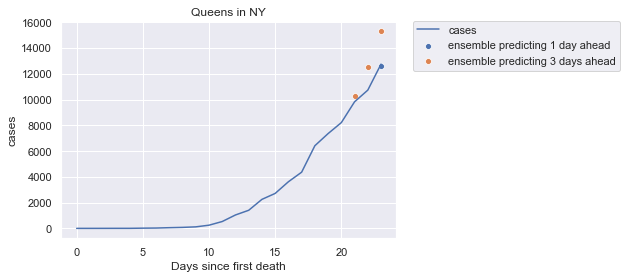

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 20553.6
PopulationEstimate2018: 2278906.0
#ICU_beds: 129
MedianAge2010: 37.2
Smokers_Percentage: 12.42777748
DiabetesPercentage: 10.2
HeartDiseaseMortality: 180.0
#Hospitals: 6


Kings in NY


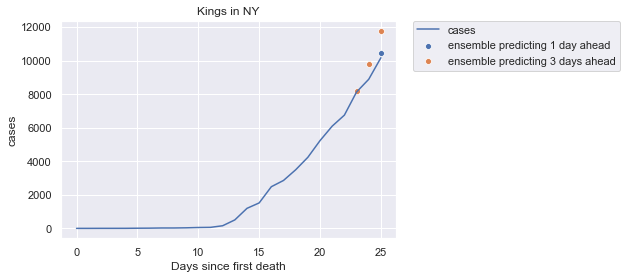

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 35369.2
PopulationEstimate2018: 2582830.0
#ICU_beds: 318
MedianAge2010: 34.1
Smokers_Percentage: 13.840801998
DiabetesPercentage: 9.7
HeartDiseaseMortality: 195.8
#Hospitals: 12


Bronx in NY


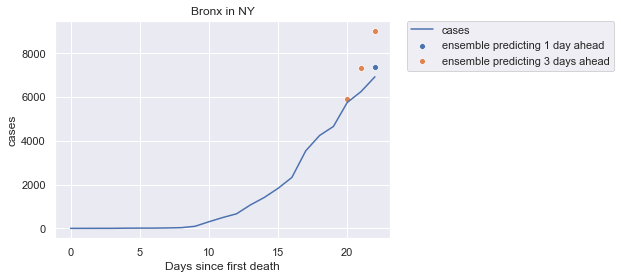

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 32903.3
PopulationEstimate2018: 1432132.0
#ICU_beds: 270
MedianAge2010: 32.8
Smokers_Percentage: 15.921168722
DiabetesPercentage: 12.3
HeartDiseaseMortality: 201.3
#Hospitals: 6


King in WA


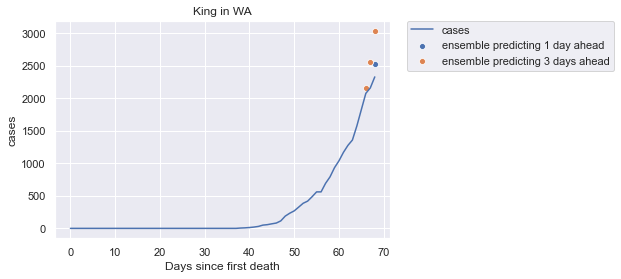

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 912.9
PopulationEstimate2018: 2233163.0
#ICU_beds: 450
MedianAge2010: 37.1
Smokers_Percentage: 8.8150454593
DiabetesPercentage: 7.1
HeartDiseaseMortality: 118.9
#Hospitals: 17


New York in NY


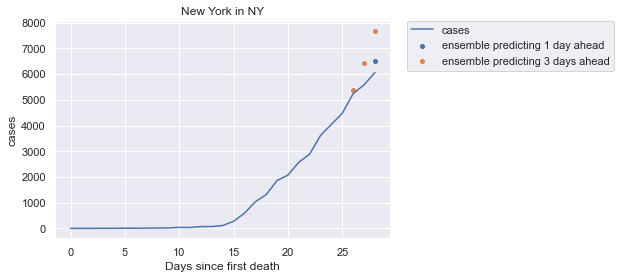

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 69468.4
PopulationEstimate2018: 1628701.0
#ICU_beds: 761
MedianAge2010: 36.4
Smokers_Percentage: 12.41823421
DiabetesPercentage: 6.5
HeartDiseaseMortality: 143.5
#Hospitals: 12


Orleans in LA


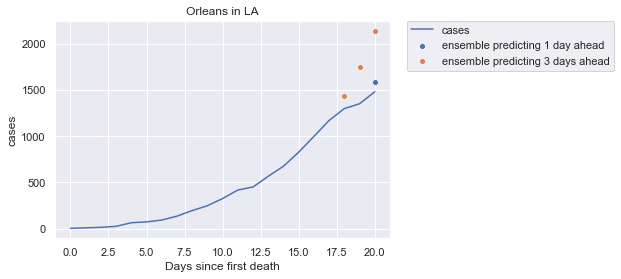

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2029.4
PopulationEstimate2018: 391006.0
#ICU_beds: 111
MedianAge2010: 34.6
Smokers_Percentage: 22.609624129
DiabetesPercentage: 10.3
HeartDiseaseMortality: 189.7
#Hospitals: 5


Wayne in MI


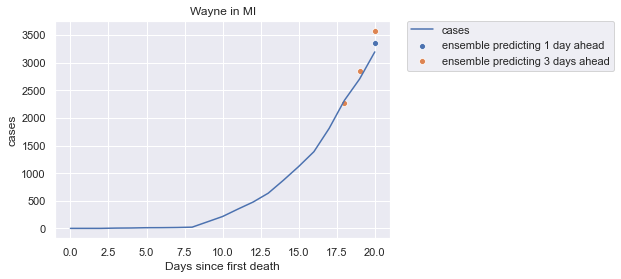

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2974.4
PopulationEstimate2018: 1753893.0
#ICU_beds: 586
MedianAge2010: 37.3
Smokers_Percentage: 21.055529729
DiabetesPercentage: 10.3
HeartDiseaseMortality: 259.2
#Hospitals: 14


Richmond in NY


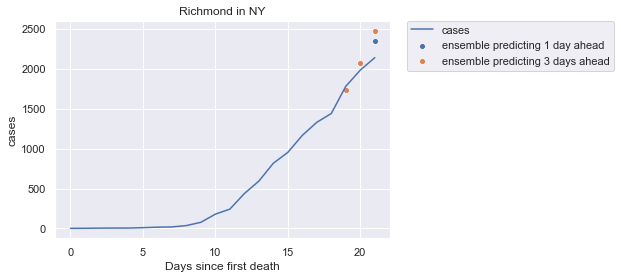

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 8030.3
PopulationEstimate2018: 476179.0
#ICU_beds: 114
MedianAge2010: 38.4
Smokers_Percentage: 15.373417772
DiabetesPercentage: 9.6
HeartDiseaseMortality: 239.6
#Hospitals: 2


Nassau in NY


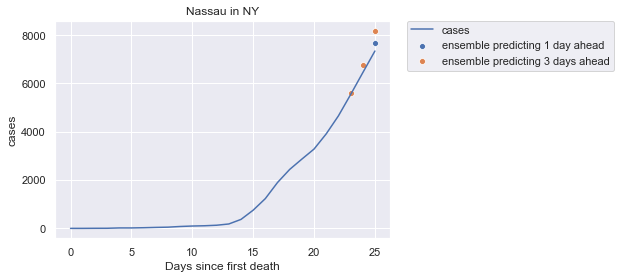

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 4704.8
PopulationEstimate2018: 1358343.0
#ICU_beds: 461
MedianAge2010: 41.1
Smokers_Percentage: 11.225364644
DiabetesPercentage: 7.2
HeartDiseaseMortality: 188.2
#Hospitals: 10


Oakland in MI


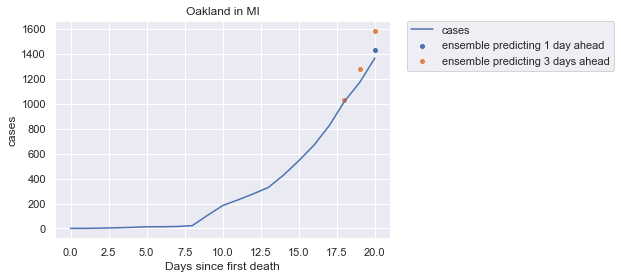

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1385.8
PopulationEstimate2018: 1259201.0
#ICU_beds: 409
MedianAge2010: 40.2
Smokers_Percentage: 12.308266081
DiabetesPercentage: 7.7
HeartDiseaseMortality: 181.4
#Hospitals: 12


Suffolk in NY


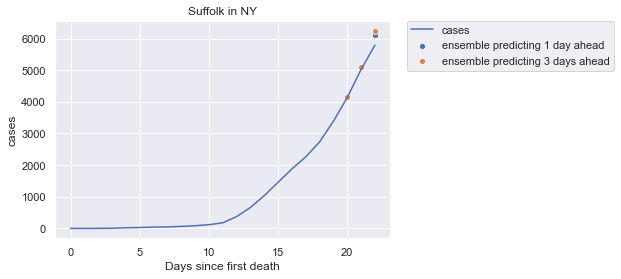

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1637.4
PopulationEstimate2018: 1481093.0
#ICU_beds: 281
MedianAge2010: 39.8
Smokers_Percentage: 12.625481467
DiabetesPercentage: 6.8
HeartDiseaseMortality: 181.8
#Hospitals: 10


Cook in IL


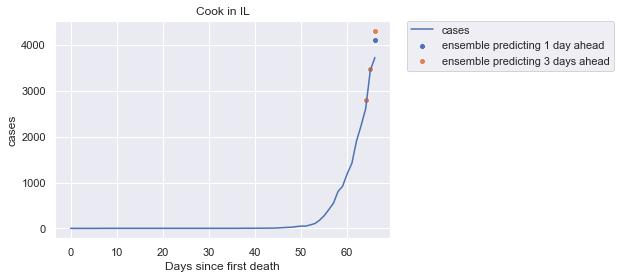

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 5495.1
PopulationEstimate2018: 5180493.0
#ICU_beds: 1606
MedianAge2010: 35.3
Smokers_Percentage: 13.776183162
DiabetesPercentage: 9
HeartDiseaseMortality: 175.1
#Hospitals: 46


Los Angeles in CA


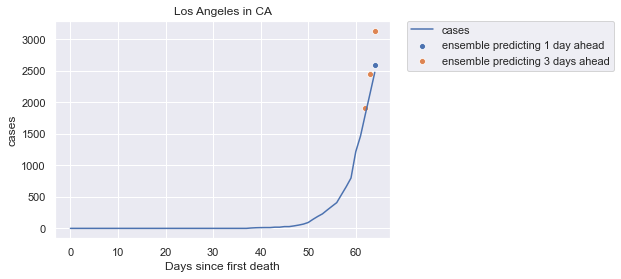

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2419.6
PopulationEstimate2018: 10105518.0
#ICU_beds: 2126
MedianAge2010: 34.8
Smokers_Percentage: 10.847678109
DiabetesPercentage: 8.1
HeartDiseaseMortality: 150.8
#Hospitals: 76


Jefferson in LA


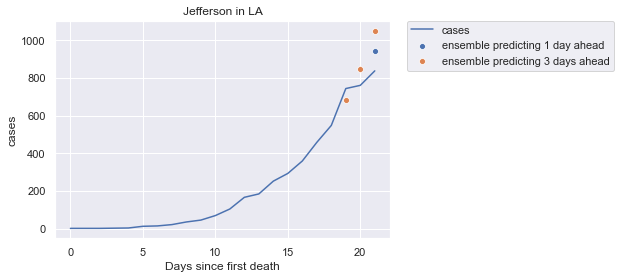

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1463.1
PopulationEstimate2018: 434051.0
#ICU_beds: 215
MedianAge2010: 38.4
Smokers_Percentage: 18.743669593
DiabetesPercentage: 12.7
HeartDiseaseMortality: 178.7
#Hospitals: 5


Bergen in NJ


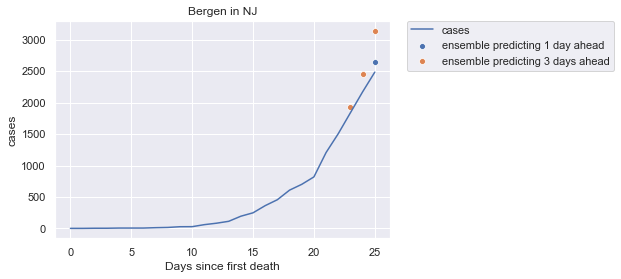

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 3884.5
PopulationEstimate2018: 936692.0
#ICU_beds: 147
MedianAge2010: 41.1
Smokers_Percentage: 11.410986988
DiabetesPercentage: 6.8
HeartDiseaseMortality: 140.1
#Hospitals: 6


Snohomish in WA


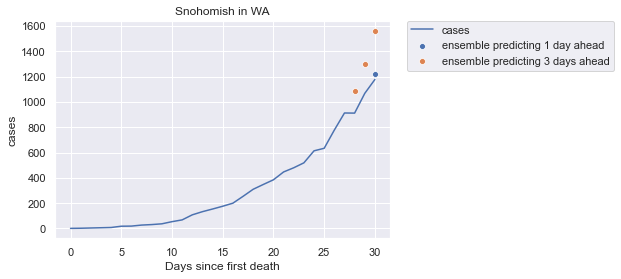

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 341.8
PopulationEstimate2018: 814901.0
#ICU_beds: 72
MedianAge2010: 37.1
Smokers_Percentage: 12.962308599
DiabetesPercentage: 7.7
HeartDiseaseMortality: 131.9
#Hospitals: 4


Santa Clara in CA


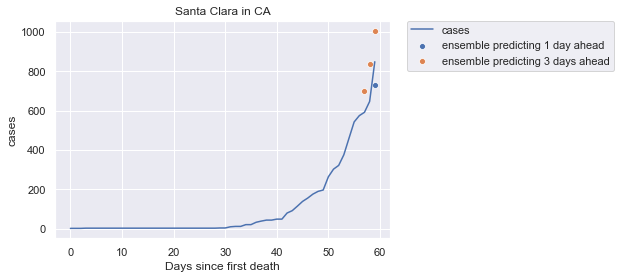

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1381.0
PopulationEstimate2018: 1937570.0
#ICU_beds: 313
MedianAge2010: 36.2
Smokers_Percentage: 8.2690140125
DiabetesPercentage: 7.3
HeartDiseaseMortality: 104.2
#Hospitals: 9


Macomb in MI


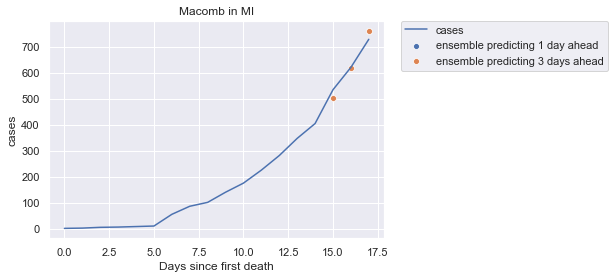

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1754.9
PopulationEstimate2018: 874759.0
#ICU_beds: 122
MedianAge2010: 39.9
Smokers_Percentage: 18.558096157
DiabetesPercentage: 9.5
HeartDiseaseMortality: 196.6
#Hospitals: 4


Fairfield in CT


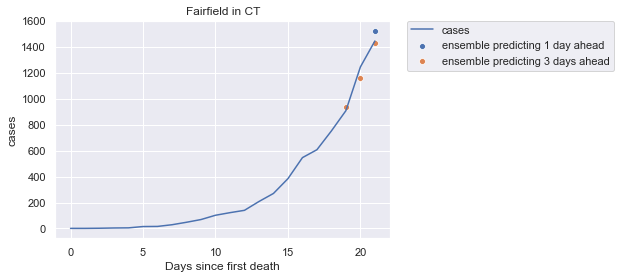

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1467.2
PopulationEstimate2018: 943823.0
#ICU_beds: 173
MedianAge2010: 39.5
Smokers_Percentage: 10.157896011
DiabetesPercentage: 6.4
HeartDiseaseMortality: 137.1
#Hospitals: 6


Essex in NJ


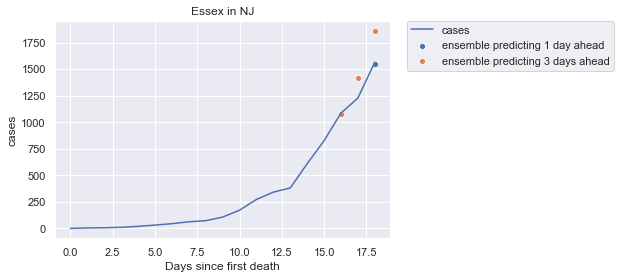

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 6211.5
PopulationEstimate2018: 799767.0
#ICU_beds: 267
MedianAge2010: 36.4
Smokers_Percentage: 14.235389268
DiabetesPercentage: 9.9
HeartDiseaseMortality: 169.8
#Hospitals: 7


Westchester in NY


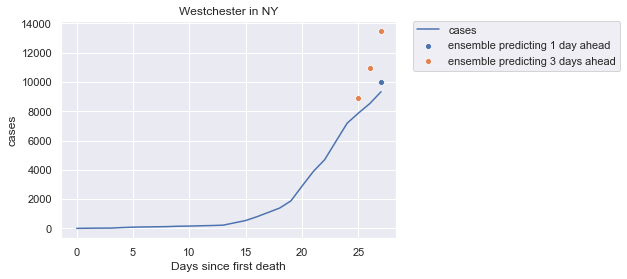

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2204.7
PopulationEstimate2018: 967612.0
#ICU_beds: 179
MedianAge2010: 40.0
Smokers_Percentage: 11.37154602
DiabetesPercentage: 6.4
HeartDiseaseMortality: 146.8
#Hospitals: 9


Dougherty in GA


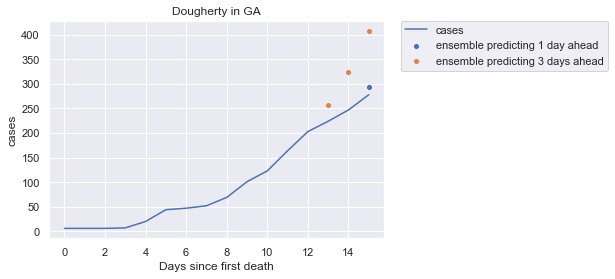

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 287.7
PopulationEstimate2018: 91243.0
#ICU_beds: 50
MedianAge2010: 33.2
Smokers_Percentage: 21.607553194
DiabetesPercentage: 13.8
HeartDiseaseMortality: 178.8
#Hospitals: 1


Rockland in NY


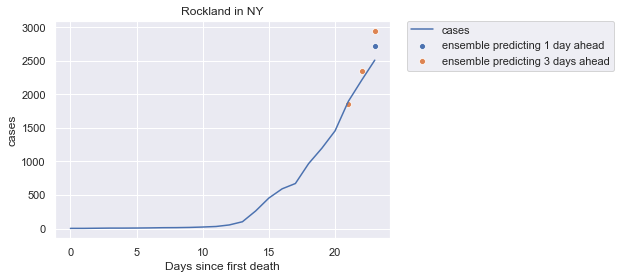

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1796.0
PopulationEstimate2018: 325695.0
#ICU_beds: 39
MedianAge2010: 36.7
Smokers_Percentage: 12.165288495
DiabetesPercentage: 6.9
HeartDiseaseMortality: 150.9
#Hospitals: 3


Fulton in GA


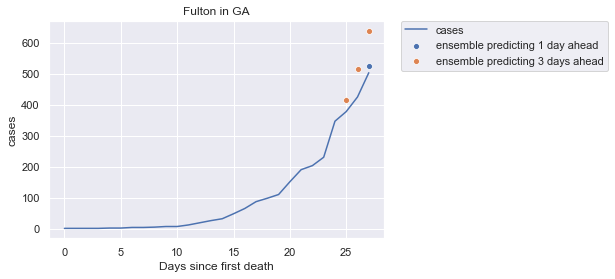

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1748.1
PopulationEstimate2018: 1050114.0
#ICU_beds: 538
MedianAge2010: 34.2
Smokers_Percentage: 14.925509463
DiabetesPercentage: 8.3
HeartDiseaseMortality: 157.6
#Hospitals: 7


Clark in NV


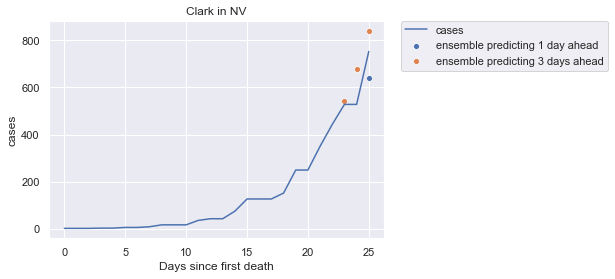

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 247.3
PopulationEstimate2018: 2231647.0
#ICU_beds: 535
MedianAge2010: 35.5
Smokers_Percentage: 16.979704666
DiabetesPercentage: 10
HeartDiseaseMortality: 204.3
#Hospitals: 19


Middlesex in NJ


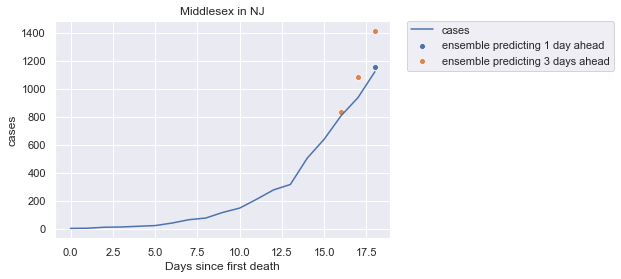

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2621.6
PopulationEstimate2018: 829685.0
#ICU_beds: 185
MedianAge2010: 37.2
Smokers_Percentage: 10.970467888
DiabetesPercentage: 9.7
HeartDiseaseMortality: 154.3
#Hospitals: 5


Marion in IN


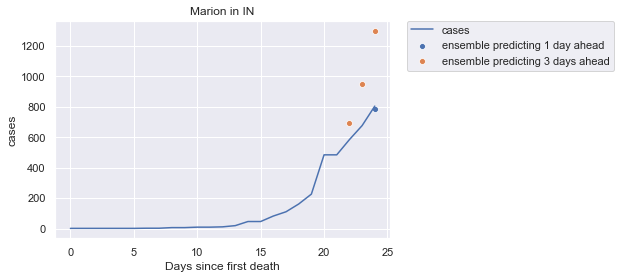

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2279.6
PopulationEstimate2018: 954670.0
#ICU_beds: 526
MedianAge2010: 33.9
Smokers_Percentage: 19.241619979
DiabetesPercentage: 11.6
HeartDiseaseMortality: 183.2
#Hospitals: 9


Broward in FL


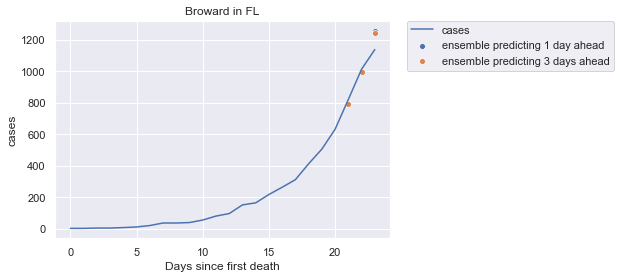

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1444.9
PopulationEstimate2018: 1951260.0
#ICU_beds: 587
MedianAge2010: 39.7
Smokers_Percentage: 14.593792551
DiabetesPercentage: 8.1
HeartDiseaseMortality: 146.9
#Hospitals: 14


Morris in NJ


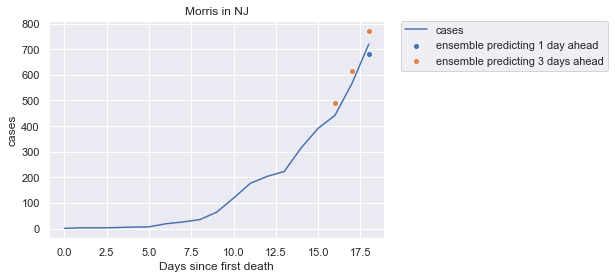

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1069.8
PopulationEstimate2018: 494228.0
#ICU_beds: 91
MedianAge2010: 41.3
Smokers_Percentage: 12.111935176
DiabetesPercentage: 6.3
HeartDiseaseMortality: 143.5
#Hospitals: 3


El Paso in CO


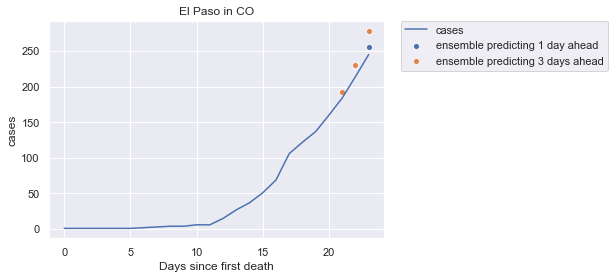

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 292.6
PopulationEstimate2018: 713856.0
#ICU_beds: 95
MedianAge2010: 34.1
Smokers_Percentage: 14.264909913
DiabetesPercentage: 6.5
HeartDiseaseMortality: 135.6
#Hospitals: 3


Monmouth in NJ


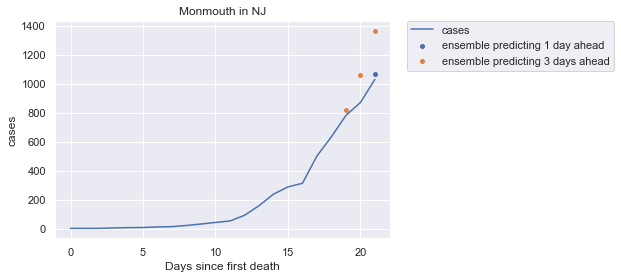

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 1344.7
PopulationEstimate2018: 621354.0
#ICU_beds: 152
MedianAge2010: 41.3
Smokers_Percentage: 13.360452416
DiabetesPercentage: 7.5
HeartDiseaseMortality: 159.1
#Hospitals: 5


Dallas in TX


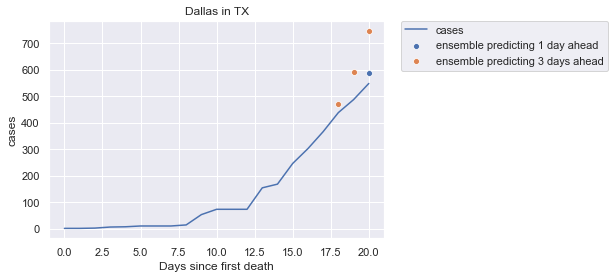

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2718.0
PopulationEstimate2018: 2637772.0
#ICU_beds: 614
MedianAge2010: 32.5
Smokers_Percentage: 14.893746644
DiabetesPercentage: 8.4
HeartDiseaseMortality: 171.3
#Hospitals: 24


Cobb in GA


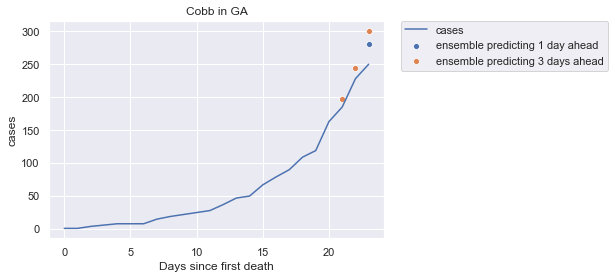

<Figure size 3000x2000 with 0 Axes>

PopulationDensityperSqMile2010: 2026.5
PopulationEstimate2018: 756865.0
#ICU_beds: 119
MedianAge2010: 35.4
Smokers_Percentage: 12.634027364
DiabetesPercentage: 8.4
HeartDiseaseMortality: 139.7
#Hospitals: 2




In [116]:
df = df.sort_values(by='max_deaths',ascending=False)
for i in range(len(df)):
    row = df.iloc[i]
    # If number of deaths greater than 10
    if max(row['deaths']) > 10:
        print(row['CountyName']+' in '+row['StateNameAbbreviation'])
        plot_prediction(row)
        for v in very_important_vars:
            print(v+ ': '+str(row[v])) #+';\t contrib: '+ str(feature_vals[v]*float(row[v])))
        print('\n')